<a href="https://colab.research.google.com/github/anjalii-s/data-mining/blob/main/Python_code_website_evaluation_using_opinion_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VADER

Path to dataset files: /kaggle/input/amazon-sales-dataset

Sample reviews and ratings:
                                      review_content  rating
0  Looks durable Charging is fine tooNo complains...     4.2
1  I ordered this cable to connect my phone to An...     4.0
2  Not quite durable and sturdy,https://m.media-a...     3.9
3  Good product,long wire,Charges good,Nice,I bou...     4.2
4  Bought this instead of original apple, does th...     4.2

Analysis Results:
Total reviews: 1465
Valid ratings: 1464
Overall rating: 4.10/5

Aspect Breakdown:

Product Authenticity:
  Total mentions: 1143
  Positive: 1079 (94.4%)
  Negative: 54 (4.7%)
  Neutral: 10 (0.9%)
  Rating: 4.81/5

Customer Support :
  Total mentions: 417
  Positive: 398 (95.4%)
  Negative: 16 (3.8%)
  Neutral: 3 (0.7%)
  Rating: 4.85/5

Delivery Reliability:
  Total mentions: 374
  Positive: 363 (97.1%)
  Negative: 8 (2.1%)
  Neutral: 3 (0.8%)
  Rating: 4.91/5

Value For Money:
  Total mentions: 1001
  Positive: 956 (95.5%

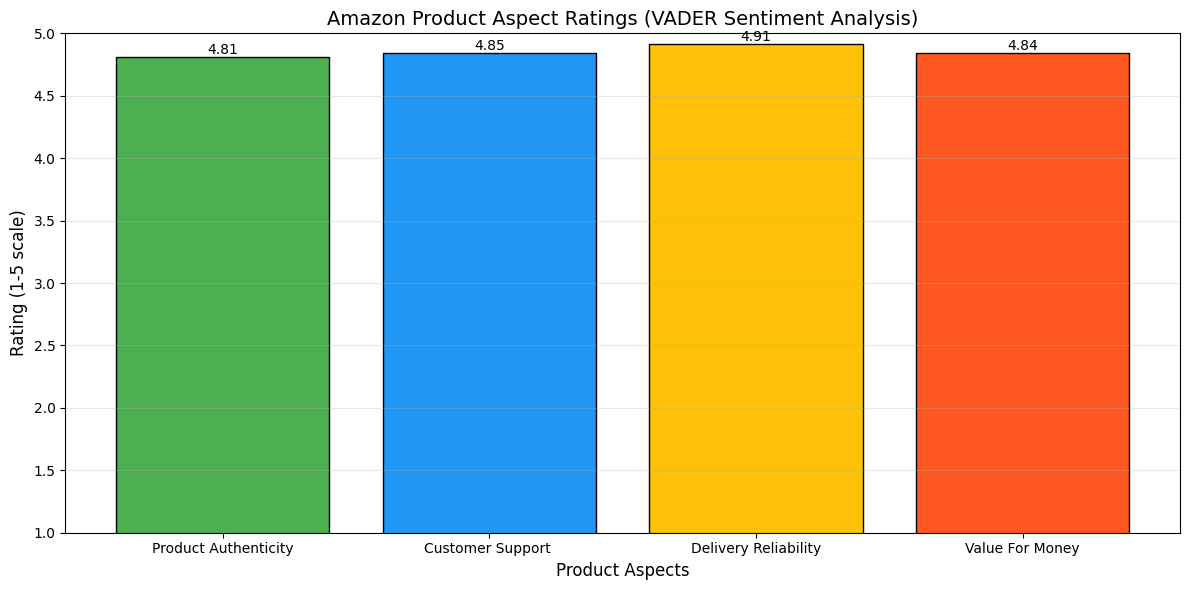

In [ ]:
import kagglehub
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import os

# Ensure all required NLTK data is downloaded
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)

from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the Amazon Sales Dataset
try:
    path = kagglehub.dataset_download("karkavelrajaj/amazon-sales-dataset")
    print("Path to dataset files:", path)

    # Locate the CSV file
    csv_file = os.path.join(path, 'amazon.csv')

    # Load the dataset
    df = pd.read_csv(csv_file)
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Check required columns
if 'review_content' not in df.columns:
    print("Error: 'review_content' column not found")
    exit()

# Clean the rating column - convert to numeric, handle non-numeric values
if 'rating' in df.columns:
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

print("\nSample reviews and ratings:")
print(df[['review_content', 'rating']].head())

# Initialize VADER
vader = SentimentIntensityAnalyzer()

# Aspect definitions
aspects = {
    'product authenticity': ['quality', 'durable', 'sturdy', 'break', 'broken', 'last', 'material'],
    'customer support ': ['support', 'helpful', 'rude', 'response', 'service', 'unhelpful'],
    'delivery reliability': ['delivery', 'ship', 'arrive', 'late', 'early', 'shipping', 'package'],
    'value for money': ['price', 'worth', 'expensive', 'cheap', 'affordable', 'overpriced']
}

def analyze_sentiment(text):
    """Analyze sentiment using VADER with error handling"""
    if not isinstance(text, str) or not text.strip():
        return 'neutral'
    try:
        scores = vader.polarity_scores(text)
        if scores['compound'] >= 0.05:
            return 'positive'
        elif scores['compound'] <= -0.05:
            return 'negative'
        return 'neutral'
    except:
        return 'neutral'

# Initialize results with all sentiment categories
results = {
    aspect: {
        'positive': 0,
        'negative': 0,
        'neutral': 0,
        'total': 0
    } for aspect in aspects
}

overall_rating = 0
valid_ratings = 0

# Process reviews
for _, row in df.iterrows():
    review_text = row['review_content'] if pd.notna(row['review_content']) else ''

    # Safely get rating (already converted to numeric)
    rating = row['rating'] if 'rating' in df.columns and pd.notna(row['rating']) else None

    sentiment = analyze_sentiment(review_text)

    # Check for aspect mentions
    text_lower = review_text.lower()
    for aspect, keywords in aspects.items():
        for keyword in keywords:
            if keyword in text_lower:
                results[aspect]['total'] += 1
                results[aspect][sentiment] += 1
                break  # Count each aspect only once per review

    # Track overall rating if available
    if rating is not None:
        overall_rating += rating
        valid_ratings += 1

# Calculate ratings (1-5 scale)
for aspect in results:
    total = results[aspect]['total']
    if total > 0:
        pos = results[aspect]['positive']
        neg = results[aspect]['negative']
        # Scale rating between 1-5 based on sentiment ratio
        results[aspect]['rating'] = 1 + 4 * (pos / (pos + neg)) if (pos + neg) > 0 else 3.0
    else:
        results[aspect]['rating'] = 3.0  # Neutral

# Calculate overall average rating
overall_rating = overall_rating / valid_ratings if valid_ratings > 0 else 0

# Print results
print(f"\nAnalysis Results:")
print(f"Total reviews: {len(df)}")
print(f"Valid ratings: {valid_ratings}")
print(f"Overall rating: {overall_rating:.2f}/5")

print("\nAspect Breakdown:")
for aspect, data in results.items():
    print(f"\n{aspect.replace('_', ' ').title()}:")
    print(f"  Total mentions: {data['total']}")
    print(f"  Positive: {data['positive']} ({data['positive']/data['total']*100:.1f}%)" if data['total'] > 0 else "  Positive: 0")
    print(f"  Negative: {data['negative']} ({data['negative']/data['total']*100:.1f}%)" if data['total'] > 0 else "  Negative: 0")
    print(f"  Neutral: {data['neutral']} ({data['neutral']/data['total']*100:.1f}%)" if data['total'] > 0 else "  Neutral: 0")
    print(f"  Rating: {data['rating']:.2f}/5")

# Visualization
plt.figure(figsize=(12, 6))
aspect_names = [a.replace('_', ' ').title() for a in aspects]
ratings = [results[a]['rating'] for a in aspects]

colors = ['#4CAF50', '#2196F3', '#FFC107', '#FF5722']
bars = plt.bar(aspect_names, ratings, color=colors, edgecolor='black')

plt.title('Amazon Product Aspect Ratings (VADER Sentiment Analysis)', fontsize=14)
plt.xlabel('Product Aspects', fontsize=12)
plt.ylabel('Rating (1-5 scale)', fontsize=12)
plt.ylim(1, 5)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('amazon_aspect_ratings_vader.png', dpi=300)
plt.show()

# BERT

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Device set to use cpu



BERT Aspect Analysis Results:
Product Authenticity: 3.49/5 (based on 710 reviews)
Customer Support: 3.44/5 (based on 368 reviews)
Delivery Reliability: 3.35/5 (based on 220 reviews)
Value For Money: 3.50/5 (based on 688 reviews)


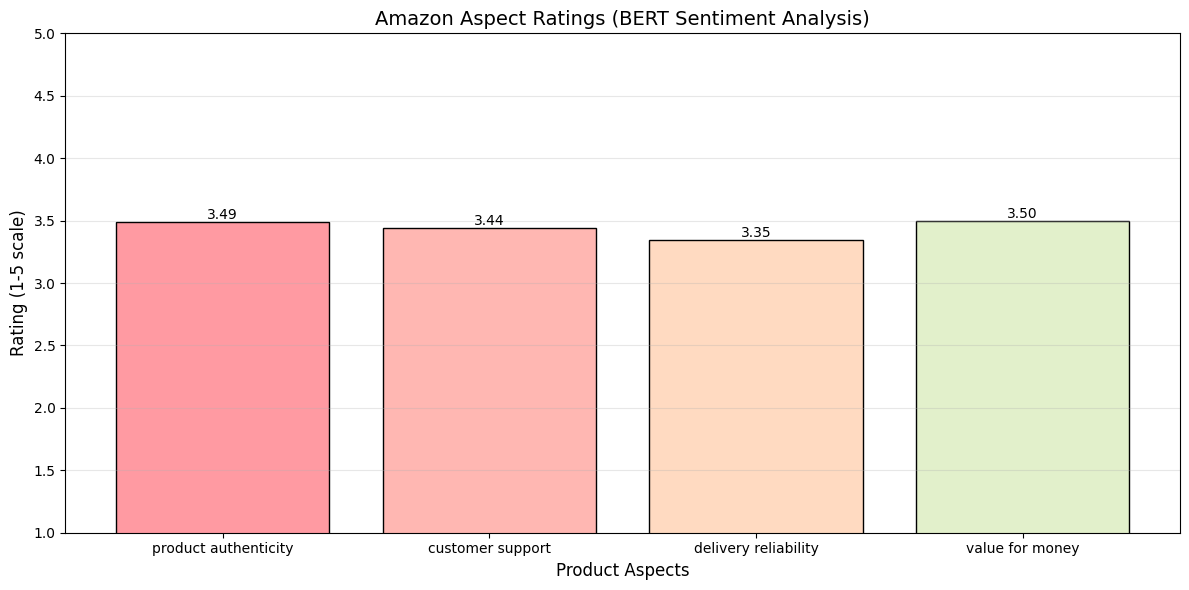

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import matplotlib.pyplot as plt

# Load dataset (assuming you already have df from previous code)
# df = pd.read_csv('amazon.csv')

# Initialize BERT model for sentiment analysis
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Create sentiment analysis pipeline
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

# Aspect keywords (same as VADER implementation for fair comparison)
aspects = {
    'product authenticity': ['quality', 'durable', 'material', 'genuine', 'fake'],
    'customer support': ['support', 'service', 'response', 'help', 'complaint'],
    'delivery reliability': ['delivery', 'shipping', 'arrived', 'late', 'early'],
    'value for money': ['price', 'worth', 'expensive', 'cheap', 'affordable']
}

def bert_aspect_sentiment(text, aspect_keywords):
    """Analyze sentiment for specific aspects using BERT"""
    if not isinstance(text, str):
        return 3.0  # Neutral if no text

    # Check if any aspect keyword exists in text
    text_lower = text.lower()
    if not any(keyword in text_lower for keyword in aspect_keywords):
        return None  # Skip if no aspect mentioned

    # Truncate to BERT's max length (512 tokens)
    truncated_text = text[:512]

    try:
        result = sentiment_analyzer(truncated_text)[0]
        # Convert BERT's 1-5 star rating to 1-5 scale
        return float(result['label'].split()[0])
    except:
        return 3.0  # Neutral if analysis fails

# Initialize results storage
bert_results = {aspect: [] for aspect in aspects}

# Process reviews (sampling for speed - remove .sample() for full analysis)
for _, row in df.sample(1000).iterrows():  # Reduced for demo - increase for better accuracy
    review = str(row['review_content'])

    for aspect, keywords in aspects.items():
        score = bert_aspect_sentiment(review, keywords)
        if score is not None:
            bert_results[aspect].append(score)

# Calculate average ratings
final_ratings = {
    aspect: sum(scores)/len(scores) if scores else 3.0
    for aspect, scores in bert_results.items()
}

# Print results
print("\nBERT Aspect Analysis Results:")
for aspect, rating in final_ratings.items():
    print(f"{aspect.title()}: {rating:.2f}/5 (based on {len(bert_results[aspect])} reviews)")

# Visualization for comparison with VADER
plt.figure(figsize=(12, 6))
colors = ['#FF9AA2', '#FFB7B2', '#FFDAC1', '#E2F0CB']
bars = plt.bar(final_ratings.keys(), final_ratings.values(), color=colors, edgecolor='black')

plt.title('Amazon Aspect Ratings (BERT Sentiment Analysis)', fontsize=14)
plt.xlabel('Product Aspects', fontsize=12)
plt.ylabel('Rating (1-5 scale)', fontsize=12)
plt.ylim(1, 5)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('bert_aspect_ratings.png', dpi=300)
plt.show()

# Roberta (not in presentation)

In [ ]:
import kagglehub
import pandas as pd
import nltk
import os
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from nltk.tokenize import word_tokenize

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Download the Amazon Sales Dataset
try:
    path = kagglehub.dataset_download("karkavelrajaj/amazon-sales-dataset")
    print("Path to dataset files:", path)

    # Locate the CSV file
    csv_file = os.path.join(path, 'amazon.csv')

    # Load the dataset
    df = pd.read_csv(csv_file)
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Check required columns
if 'review_content' not in df.columns:
    print("Error: 'review_content' column not found")
    exit()

# Clean the rating column - convert to numeric, handle non-numeric values
if 'rating' in df.columns:
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

print("\nSample reviews and ratings:")
print(df[['review_content', 'rating']].head())

# Initialize RoBERTa sentiment analyzer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Aspect definitions
aspects = {
    'product authenticity': ['quality', 'durable', 'sturdy', 'break', 'broken', 'last', 'material'],
    'customer support quality': ['support', 'helpful', 'rude', 'response', 'service', 'unhelpful'],
    'delivery reliability': ['delivery', 'ship', 'arrive', 'late', 'early', 'shipping', 'package'],
    'value for money': ['price', 'worth', 'expensive', 'cheap', 'affordable', 'overpriced']
}

def analyze_sentiment(text):
    """Analyze sentiment using RoBERTa with error handling"""
    if not isinstance(text, str) or not text.strip():
        return 'neutral'
    try:
        result = sentiment_analyzer(text, truncation=True, max_length=512)[0]
        label = result['label'].lower()
        if 'positive' in label:
            return 'positive'
        elif 'negative' in label:
            return 'negative'
        return 'neutral'
    except:
        return 'neutral'

# Initialize results with all sentiment categories
results = {
    aspect: {
        'positive': 0,
        'negative': 0,
        'neutral': 0,
        'total': 0
    } for aspect in aspects
}

overall_rating = 0
valid_ratings = 0

# Process reviews
for _, row in df.iterrows():
    review_text = row['review_content'] if pd.notna(row['review_content']) else ''

    # Safely get rating (already converted to numeric)
    rating = row['rating'] if 'rating' in df.columns and pd.notna(row['rating']) else None

    sentiment = analyze_sentiment(review_text)

    # Check for aspect mentions
    text_lower = review_text.lower()
    for aspect, keywords in aspects.items():
        for keyword in keywords:
            if keyword in text_lower:
                results[aspect]['total'] += 1
                results[aspect][sentiment] += 1
                break  # Count each aspect only once per review

    # Track overall rating if available
    if rating is not None:
        overall_rating += rating
        valid_ratings += 1

# Calculate ratings (1-5 scale)
for aspect in results:
    total = results[aspect]['total']
    if total > 0:
        pos = results[aspect]['positive']
        neg = results[aspect]['negative']
        # Scale rating between 1-5 based on sentiment ratio
        results[aspect]['rating'] = 1 + 4 * (pos / (pos + neg)) if (pos + neg) > 0 else 3.0
    else:
        results[aspect]['rating'] = 3.0  # Neutral

# Calculate overall average rating
overall_rating = overall_rating / valid_ratings if valid_ratings > 0 else 0

# Print results
print(f"\nAnalysis Results (RoBERTa):")
print(f"Total reviews: {len(df)}")
print(f"Valid ratings: {valid_ratings}")
print(f"Overall rating: {overall_rating:.2f}/5")

print("\nAspect Breakdown:")
for aspect, data in results.items():
    print(f"\n{aspect.title()}:")
    print(f"  Total mentions: {data['total']}")
    print(f"  Positive: {data['positive']} ({data['positive']/data['total']*100:.1f}%)" if data['total'] > 0 else "  Positive: 0")
    print(f"  Negative: {data['negative']} ({data['negative']/data['total']*100:.1f}%)" if data['total'] > 0 else "  Negative: 0")
    print(f"  Neutral: {data['neutral']} ({data['neutral']/data['total']*100:.1f}%)" if data['total'] > 0 else "  Neutral: 0")
    print(f"  Rating: {data['rating']:.2f}/5")

Path to dataset files: /kaggle/input/amazon-sales-dataset

Sample reviews and ratings:
                                      review_content  rating
0  Looks durable Charging is fine tooNo complains...     4.2
1  I ordered this cable to connect my phone to An...     4.0
2  Not quite durable and sturdy,https://m.media-a...     3.9
3  Good product,long wire,Charges good,Nice,I bou...     4.2
4  Bought this instead of original apple, does th...     4.2


Device set to use cpu



Analysis Results (RoBERTa):
Total reviews: 1465
Valid ratings: 1464
Overall rating: 4.10/5

Aspect Breakdown:

Product Authenticity:
  Total mentions: 1143
  Positive: 0 (0.0%)
  Negative: 0 (0.0%)
  Neutral: 1143 (100.0%)
  Rating: 3.00/5

Customer Support Quality:
  Total mentions: 417
  Positive: 0 (0.0%)
  Negative: 0 (0.0%)
  Neutral: 417 (100.0%)
  Rating: 3.00/5

Delivery Reliability:
  Total mentions: 374
  Positive: 0 (0.0%)
  Negative: 0 (0.0%)
  Neutral: 374 (100.0%)
  Rating: 3.00/5

Value For Money:
  Total mentions: 1001
  Positive: 0 (0.0%)
  Negative: 0 (0.0%)
  Neutral: 1001 (100.0%)
  Rating: 3.00/5


#BERT

# Roberta ((not in presentation))

In [ ]:
from transformers import pipeline

# Load RoBERTa sentiment analysis pipeline
sentiment_analysis = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")

# Sample text
text = "I had an amazing experience with this product!"

# Perform sentiment analysis
result = sentiment_analysis(text)

print("Sentiment:", result[0]['label'])
print("Confidence Score:", result[0]['score'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


Sentiment: POSITIVE
Confidence Score: 0.9989166259765625


# BERT (not in presentation)

In [ ]:
from transformers import pipeline

# Load BERT sentiment analysis pipeline
sentiment_analysis = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Sample text
text = "This movie was absolutely fantastic!"

# Perform sentiment analysis
result = sentiment_analysis(text)

print("Sentiment:", result[0]['label'])
print("Confidence Score:", result[0]['score'])


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


Sentiment: 5 stars
Confidence Score: 0.9364135265350342


In [ ]:
import pandas as pd
import os
import nltk
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nltk.corpus import stopwords

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj

# SVM , Naive Bayes

In [ ]:
import pandas as pd
import nltk
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nltk.corpus import stopwords

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load dataset
df = df.dropna(subset=['review_content'])

# Step 1: Use Hugging Face transformer to assign sentiment labels
sentiment_pipeline = pipeline("sentiment-analysis")

# Optional: sample if dataset is large
# df = df.sample(1000, random_state=42)

df['sentiment'] = df['review_content'].astype(str).apply(lambda x: sentiment_pipeline(x[:512])[0]['label'])

# Step 2: Clean review text
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    return ' '.join(tokens)

df['cleaned_review'] = df['review_content'].astype(str).apply(preprocess_text)

# Step 3: Vectorize
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_review'])
y = df['sentiment']

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

print("\n🔹 SVM Results:")
print("Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds))
print(confusion_matrix(y_test, svm_preds))

# Step 6: Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

print("\n🔹 Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, nb_preds))
print(classification_report(y_test, nb_preds))
print(confusion_matrix(y_test, nb_preds))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu



🔹 SVM Results:
Accuracy: 0.7303754266211604
              precision    recall  f1-score   support

    NEGATIVE       0.72      0.50      0.59       113
    POSITIVE       0.73      0.88      0.80       180

    accuracy                           0.73       293
   macro avg       0.73      0.69      0.69       293
weighted avg       0.73      0.73      0.72       293

[[ 56  57]
 [ 22 158]]

🔹 Naive Bayes Results:
Accuracy: 0.6655290102389079
              precision    recall  f1-score   support

    NEGATIVE       0.86      0.16      0.27       113
    POSITIVE       0.65      0.98      0.78       180

    accuracy                           0.67       293
   macro avg       0.75      0.57      0.53       293
weighted avg       0.73      0.67      0.58       293

[[ 18  95]
 [  3 177]]


# voting classifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu



🔹 Voting Classifier Results:
Accuracy: 0.7167235494880546
              precision    recall  f1-score   support

    NEGATIVE       0.72      0.43      0.54       113
    POSITIVE       0.72      0.89      0.80       180

    accuracy                           0.72       293
   macro avg       0.72      0.66      0.67       293
weighted avg       0.72      0.72      0.70       293

[[ 49  64]
 [ 19 161]]


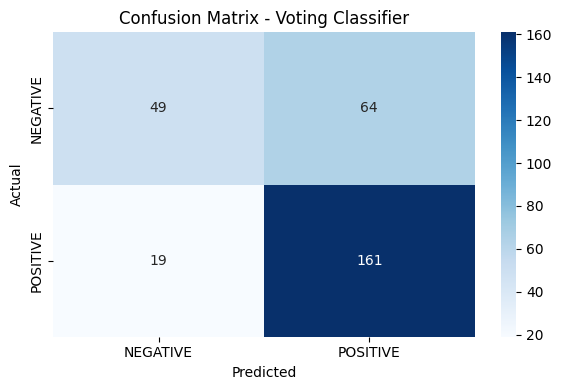

In [ ]:
import pandas as pd
import nltk
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load dataset
df = df.dropna(subset=['review_content'])

# Step 1: Auto-label reviews
sentiment_pipeline = pipeline("sentiment-analysis")
df['sentiment'] = df['review_content'].astype(str).apply(lambda x: sentiment_pipeline(x[:512])[0]['label'])

# Step 2: Text preprocessing
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    return ' '.join(tokens)

df['cleaned_review'] = df['review_content'].astype(str).apply(preprocess_text)

# Step 3: Vectorize
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_review'])
y = df['sentiment']

# Step 4: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Define base models
svm_model = SVC(probability=True)
nb_model = MultinomialNB()

# Step 6: VotingClassifier (soft voting)
voting_model = VotingClassifier(estimators=[
    ('svm', svm_model),
    ('nb', nb_model)
], voting='soft')

# Train combined model
voting_model.fit(X_train, y_train)
voting_preds = voting_model.predict(X_test)

# Step 7: Evaluate
print("\n🔹 Voting Classifier Results:")
print("Accuracy:", accuracy_score(y_test, voting_preds))
print(classification_report(y_test, voting_preds))
print(confusion_matrix(y_test, voting_preds))

# Optional: Confusion matrix heatmap
conf_mat = confusion_matrix(y_test, voting_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=voting_model.classes_, yticklabels=voting_model.classes_)
plt.title("Confusion Matrix - Voting Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


The VotingClassifier aggregates predictions from multiple classifiers (SVM, Naïve Bayes, etc.) to make a final decision.

Soft voting means that instead of choosing the most frequent class label (hard voting), it averages the predicted probabilities from all models and selects the class with the highest probability.

# rule based + ML model

# Hybrid Model Code (Rule-Based + TF-IDF + ML)

In [ ]:
import pandas as pd
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from nltk.corpus import stopwords
from transformers import pipeline

nltk.download('punkt')
nltk.download('stopwords')

# Load data

df = df.dropna(subset=['review_content'])

# Label data using sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
df['sentiment'] = df['review_content'].astype(str).apply(lambda x: sentiment_pipeline(x[:512])[0]['label'])

# 1. RULE-BASED FEATURES
def rule_based_features(row):
    text = row['review_content'].lower()

    # Safe conversion of rating to float
    try:
        rating_clean = re.sub("[^0-9.]", "", str(row['rating']))
        rating = float(rating_clean) if rating_clean else 0
    except:
        rating = 0

    features = {
        'review_length': len(text),
        'has_keywords': int(any(k in text for k in ['bad', 'worst', 'amazing', 'love', 'hate'])),
        'rating_score': rating
    }
    return pd.Series(features)


rule_features = df.apply(rule_based_features, axis=1)

# 2. TEXT CLEANING + TF-IDF
def clean_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stopwords.words('english')]
    return ' '.join(tokens)

df['cleaned_text'] = df['review_content'].astype(str).apply(clean_text)

vectorizer = TfidfVectorizer(max_features=3000)
text_features = vectorizer.fit_transform(df['cleaned_text'])

# 3. COMBINE RULE + TEXT FEATURES
import scipy
X_combined = scipy.sparse.hstack([text_features, rule_features])
y = df['sentiment']

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# 5. Model: Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# 6. Evaluation
print("\n🔹 Hybrid Model Results:")
print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu



🔹 Hybrid Model Results:
Accuracy: 0.764505119453925
              precision    recall  f1-score   support

    NEGATIVE       0.78      0.54      0.64       113
    POSITIVE       0.76      0.91      0.83       180

    accuracy                           0.76       293
   macro avg       0.77      0.72      0.73       293
weighted avg       0.77      0.76      0.75       293



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu



🔹 Hybrid Model Results:
Accuracy: 0.764505119453925
              precision    recall  f1-score   support

    NEGATIVE       0.78      0.54      0.64       113
    POSITIVE       0.76      0.91      0.83       180

    accuracy                           0.76       293
   macro avg       0.77      0.72      0.73       293
weighted avg       0.77      0.76      0.75       293


🔹 Confusion Matrix:
[[163  17]
 [ 52  61]]


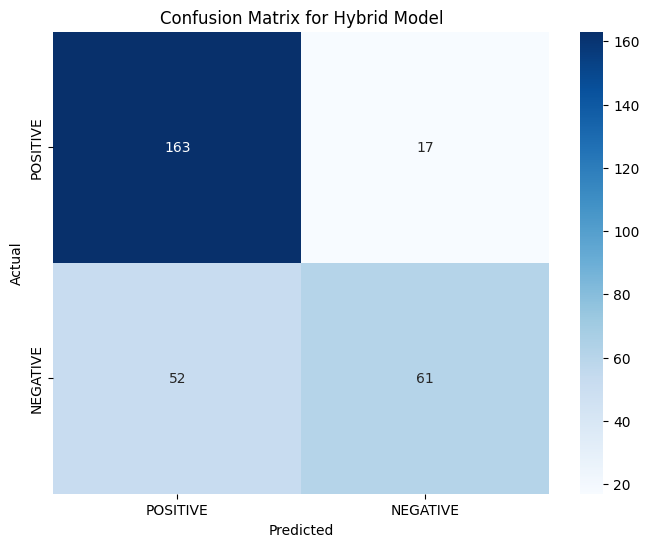

In [ ]:
import pandas as pd
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nltk.corpus import stopwords
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('punkt')
import nltk
nltk.download('punkt_tab')

nltk.download('stopwords')

# Load data (assuming df is already loaded as in the original code)
df = df.dropna(subset=['review_content'])

# Label data using sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
df['sentiment'] = df['review_content'].astype(str).apply(lambda x: sentiment_pipeline(x[:512])[0]['label'])

# 1. RULE-BASED FEATURES
def rule_based_features(row):
    text = row['review_content'].lower()
    try:
        rating_clean = re.sub("[^0-9.]", "", str(row['rating']))
        rating = float(rating_clean) if rating_clean else 0
    except:
        rating = 0
    features = {
        'review_length': len(text),
        'has_keywords': int(any(k in text for k in ['bad', 'worst', 'amazing', 'love', 'hate'])),
        'rating_score': rating
    }
    return pd.Series(features)

rule_features = df.apply(rule_based_features, axis=1)

# 2. TEXT CLEANING + TF-IDF
def clean_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stopwords.words('english')]
    return ' '.join(tokens)

df['cleaned_text'] = df['review_content'].astype(str).apply(clean_text)

vectorizer = TfidfVectorizer(max_features=3000)
text_features = vectorizer.fit_transform(df['cleaned_text'])

# 3. COMBINE RULE + TEXT FEATURES
import scipy
X_combined = scipy.sparse.hstack([text_features, rule_features])
y = df['sentiment']

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# 5. Model: Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# 6. Evaluation
print("\n🔹 Hybrid Model Results:")
print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

# 7. Confusion Matrix
print("\n🔹 Confusion Matrix:")
cm = confusion_matrix(y_test, preds, labels=['POSITIVE', 'NEGATIVE'])
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['POSITIVE', 'NEGATIVE'], yticklabels=['POSITIVE', 'NEGATIVE'])
plt.title('Confusion Matrix for Hybrid Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')

<ipython-input-24-e04edc25508b>:83: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


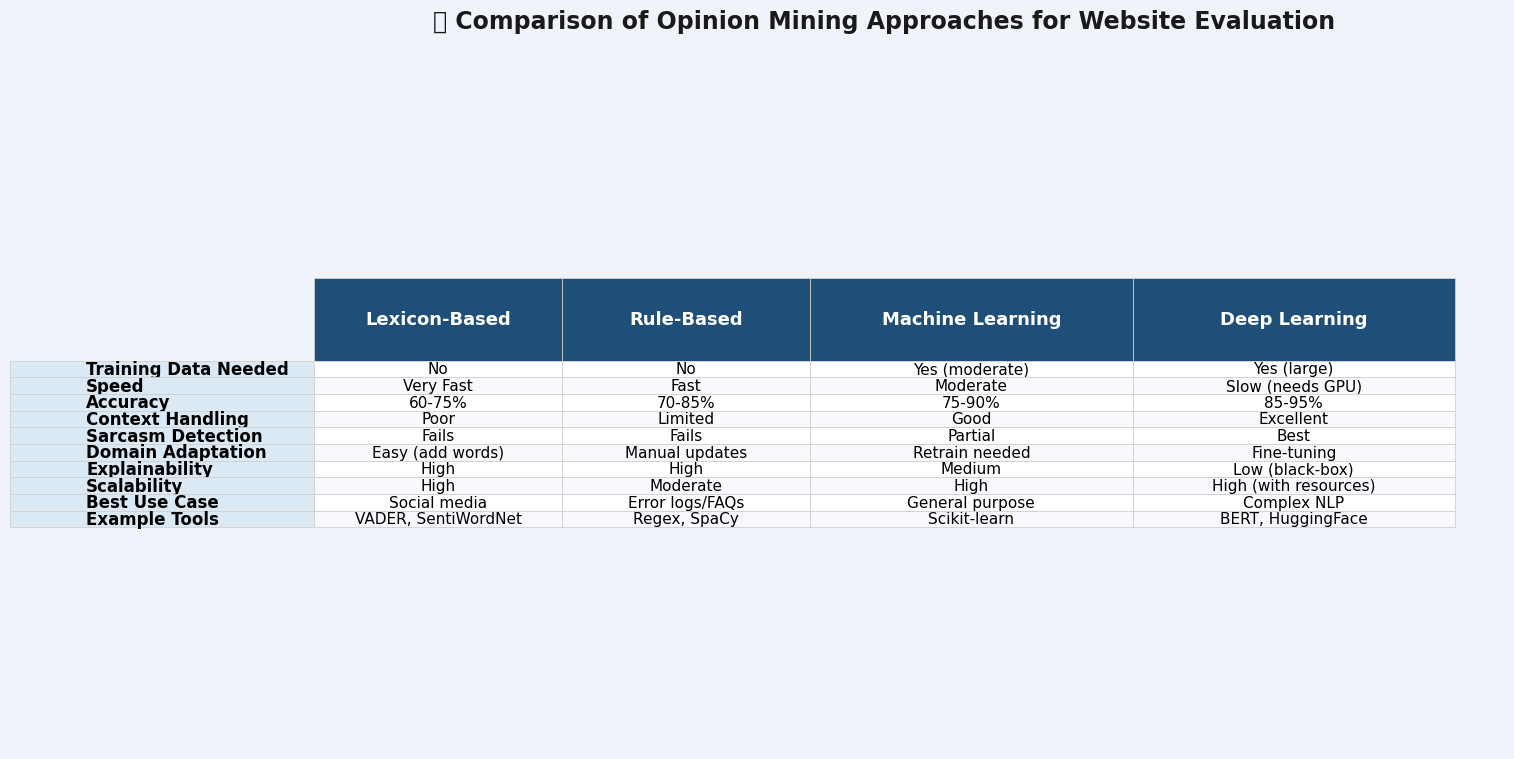

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

# Data setup
columns = ["Lexicon-Based", "Rule-Based", "Machine Learning", "Deep Learning"]
rows = [
    "Training Data Needed", "Speed", "Accuracy", "Context Handling",
    "Sarcasm Detection", "Domain Adaptation", "Explainability",
    "Scalability", "Best Use Case", "Example Tools"
]

data = [
    ["No", "No", "Yes (moderate)", "Yes (large)"],
    ["Very Fast", "Fast", "Moderate", "Slow (needs GPU)"],
    ["60-75%", "70-85%", "75-90%", "85-95%"],
    ["Poor", "Limited", "Good", "Excellent"],
    ["Fails", "Fails", "Partial", "Best"],
    ["Easy (add words)", "Manual updates", "Retrain needed", "Fine-tuning"],
    ["High", "High", "Medium", "Low (black-box)"],
    ["High", "Moderate", "High", "High (with resources)"],
    ["Social media", "Error logs/FAQs", "General purpose", "Complex NLP"],
    ["VADER, SentiWordNet", "Regex, SpaCy", "Scikit-learn", "BERT, HuggingFace"]
]

# DataFrame creation
df = pd.DataFrame(data, index=rows, columns=columns)

# Plot setup
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_axis_off()

# Title with gradient background using patch
title = "📊 Comparison of Opinion Mining Approaches for Website Evaluation"
fig.patch.set_facecolor('#f0f4fa')
plt.title(title, fontsize=17, fontweight='bold', color='#1a1a1a', pad=20)

# Color palette
colors = {
    'header_bg': '#1f4e79',
    'header_text': 'white',
    'row_header_bg': '#dbe9f4',
    'even_row': '#f8f9fc',
    'odd_row': '#ffffff',
    'text': '#000000'
}

# Column widths for better spacing
col_widths = [0.20, 0.20, 0.26, 0.26]

# Create table
table = ax.table(
    cellText=df.values,
    rowLabels=df.index,
    colLabels=df.columns,
    cellLoc='center',
    loc='center',
    colWidths=col_widths,
    edges='closed'
)

table.auto_set_font_size(False)
table.set_fontsize(12)

# Format cells
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_facecolor(colors['header_bg'])
        cell.set_text_props(color=colors['header_text'], weight='bold', size=13)
        cell.set_height(0.12)
    elif col == -1:
        cell.set_facecolor(colors['row_header_bg'])
        cell.set_text_props(weight='bold', color=colors['text'], size=12)
    else:
        bg = colors['even_row'] if row % 2 == 0 else colors['odd_row']
        cell.set_facecolor(bg)
        cell.set_text_props(color=colors['text'], size=11)
    cell.set_edgecolor('#d0d0d0')
    cell.PAD = 0.25
    cell.set_linewidth(0.6)

# Save figure
plt.savefig(
    "enhanced_sentiment_analysis_table.png",
    dpi=300,
    bbox_inches='tight',
    transparent=False
)

plt.show()


In [ ]:
import kagglehub
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import os

# Ensure all required NLTK data is downloaded
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)

from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the Amazon Sales Dataset
try:
    path = kagglehub.dataset_download("karkavelrajaj/amazon-sales-dataset")
    print("Path to dataset files:", path)

    # Locate the CSV file
    csv_file = os.path.join(path, 'amazon.csv')

    # Load the dataset
    df = pd.read_csv(csv_file)
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

df.head()

Path to dataset files: /kaggle/input/amazon-sales-dataset


,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,₹329,₹699,53%,4.2,"94,363",The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,₹154,₹399,61%,4.2,"16,905",[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj